# Marketing Mix Modeling (MMM) — Assessment Template
This notebook is built for the dataset with columns:

`week, facebook_spend, google_spend, tiktok_spend, instagram_spend, snapchat_spend, social_followers, average_price, promotions, emails_send, sms_send, revenue`

It implements a reproducible pipeline to:

- perform EDA and preprocessing (weekly seasonality, trends, zero-spend handling),
- create features (lags, log transforms, adstock placeholder),
- run a baseline model and a mediation-aware two-stage model (Google as mediator),
- use time-series-safe cross-validation, diagnostics, and sensitivity checks,
- produce outputs and save models for reproducibility.


## Notes before running
- Required packages: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`, optionally `xgboost`, `shap`, `statsmodels`.
Install with:

```
pip install -U pandas numpy scikit-learn matplotlib seaborn joblib xgboost shap statsmodels
```


In [1]:
import warnings
from typing import List, Dict, Any

warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import joblib

# Optional imports
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

try:
    import shap
except Exception:
    shap = None

plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style='whitegrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Utility functions
Reusable helpers for evaluation, plotting, and CV.

In [2]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def evaluate_preds(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        'rmse': rmse(y_true, y_pred),
        'r2': float(r2_score(y_true, y_pred)),
        'mape': float(mean_absolute_percentage_error(y_true, y_pred))
    }


def time_series_cv_metrics(model, X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> Dict[str, float]:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {'rmse': [], 'r2': [], 'mape': []}

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        m = evaluate_preds(y_test.values, preds)
        for k in metrics:
            metrics[k].append(m[k])

    return {k: float(np.mean(v)) for k, v in metrics.items()}


def plot_series(df: pd.DataFrame, date_col: str, value_col: str, title: str = '') -> None:
    plt.figure()
    plt.plot(df[date_col], df[value_col])
    plt.title(title or value_col)
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.show()


## Load data
Load CSV and show initial checks. If the file does not exist, a template is created with 104 weeks.

In [3]:
DATA_PATH = 'D:\Assessment2\Assessment 2 - MMM Weekly.csv\Assessment 2 - MMM Weekly.csv'

# Create template if not present
if not os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} not found — creating a template CSV. Replace it with your real data and re-run.")
    weeks = pd.date_range(start='2023-01-01', periods=104, freq='W')
    template = pd.DataFrame({
        'week': weeks,
        'facebook_spend': np.random.uniform(0, 1000, size=len(weeks)),
        'google_spend': np.random.uniform(0, 1200, size=len(weeks)),
        'tiktok_spend': np.random.uniform(0, 800, size=len(weeks)),
        'instagram_spend': np.random.uniform(0, 700, size=len(weeks)),
        'snapchat_spend': np.random.uniform(0, 300, size=len(weeks)),
        'social_followers': np.random.randint(10000, 20000, size=len(weeks)),
        'average_price': np.random.uniform(50, 150, size=len(weeks)),
        'promotions': np.random.choice([0,1], size=len(weeks), p=[0.8,0.2]),
        'emails_send': np.random.randint(0, 5000, size=len(weeks)),
        'sms_send': np.random.randint(0, 2000, size=len(weeks)),
        'revenue': np.random.uniform(10000, 50000, size=len(weeks))
    })
    template.to_csv(DATA_PATH, index=False)

# Load
df = pd.read_csv(DATA_PATH)
# Ensure week is datetime
if 'week' in df.columns:
    df['week'] = pd.to_datetime(df['week'])
    df = df.sort_values('week').reset_index(drop=True)

print('Loaded data shape:', df.shape)
df.head()


Loaded data shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


## Exploratory Data Analysis (EDA)
Plot main series, check missing values and correlation among numeric vars.

Null counts:
 week                0
facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
dtype: int64

Data summary:


,count,mean,min,25%,50%,75%,max,std
week,104,2024-09-11 12:00:00,2023-09-17 00:00:00,2024-03-15 06:00:00,2024-09-11 12:00:00,2025-03-10 18:00:00,2025-09-07 00:00:00,NaN
facebook_spend,104.0,5346.3025,2456.94,4538.9775,5293.78,6033.325,9325.18,1168.961177
google_spend,104.0,1543.866442,0.0,0.0,0.0,3374.205,6083.16,1863.350279
tiktok_spend,104.0,955.632212,0.0,0.0,0.0,2487.1725,4143.25,1376.993132
instagram_spend,104.0,1019.342885,0.0,0.0,0.0,2395.35,3877.99,1349.18425
snapchat_spend,104.0,747.465,0.0,0.0,0.0,1705.8725,3126.04,982.088273
social_followers,104.0,72414.509615,0.0,38318.25,81109.5,110281.25,143477.0,47778.448985
average_price,104.0,99.9625,87.56,94.2075,99.49,105.395,113.38,6.496186
promotions,104.0,0.211538,0.0,0.0,0.0,0.0,1.0,0.410377
emails_send,104.0,120691.067308,68655.0,102971.5,120237.0,136594.0,185460.0,25158.181476


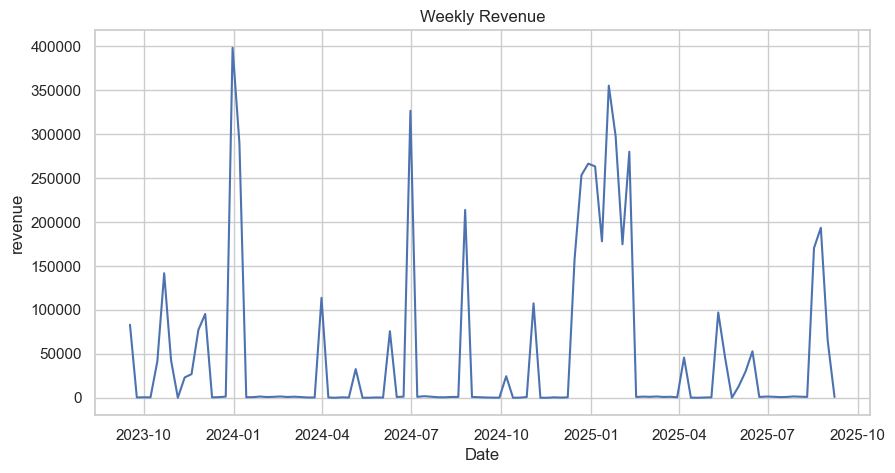

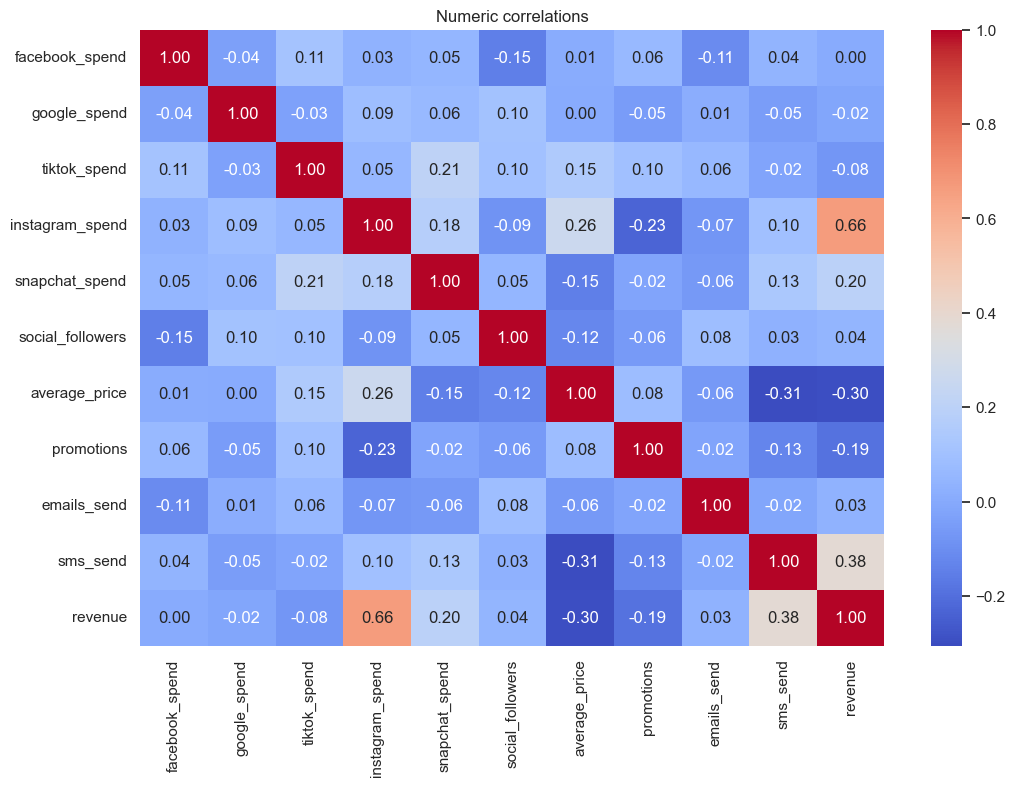

In [4]:
def eda_checks(df: pd.DataFrame) -> None:
    print('Null counts:\n', df.isnull().sum())
    print('\nData summary:')
    display(df.describe().T)

    # plot revenue
    if 'week' in df.columns and 'revenue' in df.columns:
        plot_series(df, 'week', 'revenue', title='Weekly Revenue')

    # correlation heatmap for numeric columns
    numeric = df.select_dtypes(include=[np.number]).copy()
    if not numeric.empty:
        plt.figure(figsize=(12,8))
        sns.heatmap(numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Numeric correlations')
        plt.show()

eda_checks(df)


## Feature engineering
- Log transforms for spends and price (log1p)
- Lag features (1,2 weeks)
- Week-of-year for seasonality
- Zero-spend indicators
- (Optional) Adstock function placeholder for media decay

In [5]:
def adstock(series: pd.Series, decay: float = 0.5) -> pd.Series:
    out = np.zeros(len(series))
    prev = 0.0
    for i, val in enumerate(series.fillna(0.0).astype(float)):
        out[i] = val + decay * prev
        prev = out[i]
    return pd.Series(out, index=series.index)


def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # log transforms
    spend_cols = ['facebook_spend','google_spend','tiktok_spend','instagram_spend','snapchat_spend']
    for c in spend_cols + ['average_price', 'emails_send', 'sms_send']:
        if c in df.columns:
            df[f'log_{c}'] = np.log1p(df[c].fillna(0.0))

    # adstock example for social channels (optional)
    for c in ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend']:
        if c in df.columns:
            df[f'{c}_adstock'] = adstock(df[c].fillna(0.0), decay=0.5)
            df[f'log_{c}_adstock'] = np.log1p(df[f'{c}_adstock'])

    # lags
    for c in ['revenue','google_spend'] + spend_cols:
        if c in df.columns:
            df[f'{c}_lag1'] = df[c].shift(1)
            df[f'{c}_lag2'] = df[c].shift(2)

    # week of year
    if 'week' in df.columns:
        df['week_of_year'] = df['week'].dt.isocalendar().week.astype(int)

    # zero-spend indicators
    for c in spend_cols:
        if c in df.columns:
            df[f'{c}_zero'] = (df[c].fillna(0.0) <= 0).astype(int)

    df = df.fillna(method='bfill').fillna(0.0)
    return df

# Apply
df_feat = prepare_features(df)
print('Features prepared. Shape:', df_feat.shape)
df_feat.head()


Features prepared. Shape: (104, 46)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,...,instagram_spend_lag1,instagram_spend_lag2,snapchat_spend_lag1,snapchat_spend_lag2,week_of_year,facebook_spend_zero,google_spend_zero,tiktok_spend_zero,instagram_spend_zero,snapchat_spend_zero
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,...,1841.08,1841.08,2204.72,2204.72,37,0,0,0,0,0
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,...,1841.08,1841.08,2204.72,2204.72,38,0,0,1,1,1
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,...,0.00,1841.08,0.00,2204.72,39,0,1,1,1,1
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,...,0.00,0.00,0.00,0.00,40,0,1,1,1,1
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,...,0.00,0.00,0.00,0.00,41,0,1,1,0,1


## Baseline model — Ridge regression
Create a baseline with log-spends and controls. Use TimeSeriesSplit for CV.

In [6]:
def run_baseline(df: pd.DataFrame) -> Dict[str, Any]:
    # Features for baseline
    features = [
        'log_google_spend','log_facebook_spend','log_tiktok_spend','log_instagram_spend','log_snapchat_spend',
        'log_average_price','social_followers','promotions','log_emails_send','log_sms_send',
        'google_spend_lag1','revenue_lag1'
    ]
    features = [f for f in features if f in df.columns]
    X = df[features].copy()
    y = df['revenue'].copy()

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    model = Ridge(alpha=1.0)
    cv_metrics = time_series_cv_metrics(model, X_scaled, y, n_splits=5)

    # Fit on full data for interpretation
    model.fit(X_scaled, y)

    return {'model': model, 'scaler': scaler, 'features': features, 'cv_metrics': cv_metrics}

baseline_res = run_baseline(df_feat)
print('Baseline CV metrics:', baseline_res['cv_metrics'])

# Coefficients
coef = pd.DataFrame({'feature': baseline_res['features'], 'coef': baseline_res['model'].coef_})
coef = coef.sort_values('coef', key=lambda x: x.abs(), ascending=False)
coef


Baseline CV metrics: {'rmse': 77488.31461429874, 'r2': -3.108889574529101, 'mape': 6743.9647834965635}


,feature,coef
3,log_instagram_spend,66341.740899
5,log_average_price,-35286.252265
11,revenue_lag1,15590.237562
9,log_sms_send,14832.365311
7,promotions,8453.075234
0,log_google_spend,-8253.541902
2,log_tiktok_spend,-4453.958278
8,log_emails_send,3851.753778
10,google_spend_lag1,3758.295258
1,log_facebook_spend,-1472.132680


## Mediation-aware two-stage model
Stage 1: predict google_spend from social channels. Stage 2: predict revenue using predicted google + controls.

In [7]:
def mediation_two_stage(df: pd.DataFrame) -> Dict[str, Any]:
    results = {}
    social_log = [c for c in ['log_facebook_spend','log_tiktok_spend','log_instagram_spend','log_snapchat_spend'] if c in df.columns]
    mediator = 'log_google_spend' if 'log_google_spend' in df.columns else 'google_spend'

    # Stage 1
    X1 = df[social_log].copy()
    y1 = df[mediator].copy()
    scaler1 = StandardScaler()
    X1s = pd.DataFrame(scaler1.fit_transform(X1), columns=X1.columns, index=X1.index)
    model1 = Ridge(alpha=1.0)
    cv1 = time_series_cv_metrics(model1, X1s, y1, n_splits=5)
    model1.fit(X1s, y1)
    df['google_pred'] = model1.predict(X1s)

    results['stage1'] = {'model': model1, 'scaler': scaler1, 'cv_metrics': cv1, 'features': social_log}

    # Stage 2
    controls = [c for c in ['log_average_price','social_followers','promotions','log_emails_send','log_sms_send'] if c in df.columns]
    features_stage2 = ['google_pred'] + controls
    X2 = df[features_stage2].copy()
    y2 = df['revenue'].copy()
    scaler2 = StandardScaler()
    X2s = pd.DataFrame(scaler2.fit_transform(X2), columns=X2.columns, index=X2.index)
    model2 = Ridge(alpha=1.0)
    cv2 = time_series_cv_metrics(model2, X2s, y2, n_splits=5)
    model2.fit(X2s, y2)

    results['stage2'] = {'model': model2, 'scaler': scaler2, 'cv_metrics': cv2, 'features': features_stage2}

    return results

med_res = mediation_two_stage(df_feat)
print('Stage 1 (mediator) CV:', med_res['stage1']['cv_metrics'])
print('Stage 2 (revenue) CV:', med_res['stage2']['cv_metrics'])


Stage 1 (mediator) CV: {'rmse': 4.481058438070306, 'r2': -0.3362771003546037, 'mape': 8076506482107938.0}
Stage 2 (revenue) CV: {'rmse': 87336.97548901786, 'r2': -1.1344034110084773, 'mape': 3047.9940403957758}


## Diagnostics
Residual plots, ACF for residuals (if statsmodels installed), and feature importance (coefficients).

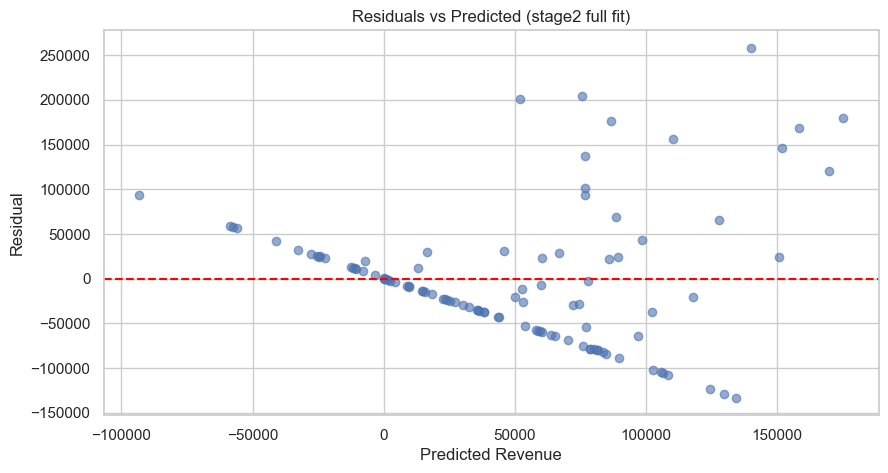

statsmodels not available — skipping ACF plot


,feature,coef
0,google_pred,39079.676909
1,log_average_price,-21563.702395
5,log_sms_send,19135.047308
3,promotions,-4730.851612
2,social_followers,-4273.933341
4,log_emails_send,1438.987536


In [8]:
# Residuals for stage2 full-sample fit
if med_res and 'stage2' in med_res:
    X_full = df_feat[med_res['stage2']['features']].copy()
    X_full_scaled = med_res['stage2']['scaler'].transform(X_full)
    preds = med_res['stage2']['model'].predict(X_full_scaled)
    residuals = df_feat['revenue'].values - preds

    plt.scatter(preds, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Revenue')
    plt.ylabel('Residual')
    plt.title('Residuals vs Predicted (stage2 full fit)')
    plt.show()

    # ACF
    try:
        import statsmodels.api as sm
        sm.graphics.tsa.plot_acf(residuals, lags=20)
        plt.title('ACF of residuals')
        plt.show()
    except Exception:
        print('statsmodels not available — skipping ACF plot')

    # Coefficients
    coef2 = pd.DataFrame({'feature': med_res['stage2']['features'], 'coef': med_res['stage2']['model'].coef_})
    display(coef2.sort_values('coef', key=lambda x: x.abs(), ascending=False))
else:
    print('Mediation results not available')


## Optional: Tree-based model (XGBoost) + SHAP
Run if XGBoost & SHAP are installed to capture nonlinearities and compute SHAP explanations.

In [9]:
if XGBRegressor is not None:
    print('XGBoost is available — training a quick model for comparison')
    tree_features = [f for f in baseline_res['features'] if f in df_feat.columns]
    X_tree = df_feat[tree_features].copy()
    y_tree = df_feat['revenue'].copy()
    # Simple train/test split using last fold
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X_tree))
    train_idx, test_idx = splits[-1]
    X_train, X_test = X_tree.iloc[train_idx], X_tree.iloc[test_idx]
    y_train, y_test = y_tree.iloc[train_idx], y_tree.iloc[test_idx]

    xgb = XGBRegressor(random_state=RANDOM_STATE, n_estimators=100, verbosity=0)
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    print('XGB test RMSE:', rmse(y_test.values, preds))

    if shap is not None:
        explainer = shap.Explainer(xgb)
        shap_values = explainer(X_test)
        shap.plots.beeswarm(shap_values)
    else:
        print('SHAP not installed — skipping explainability')
else:
    print('XGBoost not available — skip this section')


XGBoost not available — skip this section


## Sensitivity checks
Simulate impact of price and promotions on predicted revenue using the stage2 model.

In [10]:
def sensitivity_analysis(df: pd.DataFrame, med_res: Dict[str, Any]) -> pd.DataFrame:
    if med_res is None or 'stage2' not in med_res:
        raise ValueError('med_res must contain stage2 model')

    model = med_res['stage2']['model']
    scaler = med_res['stage2']['scaler']
    features = med_res['stage2']['features']

    df_sim = df.copy()
    price_col = 'average_price'
    if price_col in df_sim.columns:
        prices = np.linspace(df_sim[price_col].min()*0.9, df_sim[price_col].max()*1.1, 5)
    else:
        prices = np.linspace(0.9, 1.1, 5)
    promos = [0,1] if 'promotions' in df_sim.columns else [0]

    rows = []
    for p in prices:
        for promo in promos:
            sim = df_sim.copy()
            if price_col in sim.columns:
                sim[price_col] = p
            if 'promotions' in sim.columns:
                sim['promotions'] = promo
            # re-compute google_pred by using stage1 model
            X1 = sim[[c for c in med_res['stage1']['features']]].copy()
            X1s = med_res['stage1']['scaler'].transform(X1)
            sim['google_pred'] = med_res['stage1']['model'].predict(X1s)

            X_sim = sim[features].copy()
            X_sim_s = scaler.transform(X_sim)
            pred = model.predict(X_sim_s)
            rows.append({'price': p, 'promotions': promo, 'mean_pred_revenue': float(pred.mean())})

    return pd.DataFrame(rows)

if med_res is not None:
    sens_df = sensitivity_analysis(df_feat, med_res)
    display(sens_df)
else:
    print('Skipping sensitivity — med_res missing')


,price,promotions,mean_pred_revenue
0,78.8040,0,51504.383219
1,78.8040,1,39920.493912
2,90.2825,0,51504.383219
3,90.2825,1,39920.493912
4,101.7610,0,51504.383219
5,101.7610,1,39920.493912
6,113.2395,0,51504.383219
7,113.2395,1,39920.493912
8,124.7180,0,51504.383219
9,124.7180,1,39920.493912


## Save models and outputs
Save the trained models, scalers, and summary CSVs for reproducibility.

In [12]:
OUT_DIR = 'D:\Assessment2\dataV2\mmm_outputs_v2'
os.makedirs(OUT_DIR, exist_ok=True)

# Save baseline
joblib.dump(baseline_res['model'], os.path.join(OUT_DIR, 'baseline_ridge_model.joblib'))
joblib.dump(baseline_res['scaler'], os.path.join(OUT_DIR, 'baseline_scaler.joblib'))
# Save mediation models
joblib.dump(med_res['stage1']['model'], os.path.join(OUT_DIR, 'mediator_stage1_model.joblib'))
joblib.dump(med_res['stage1']['scaler'], os.path.join(OUT_DIR, 'mediator_stage1_scaler.joblib'))
joblib.dump(med_res['stage2']['model'], os.path.join(OUT_DIR, 'revenue_stage2_model.joblib'))
joblib.dump(med_res['stage2']['scaler'], os.path.join(OUT_DIR, 'revenue_stage2_scaler.joblib'))

# Save coefficients and CV metrics
coef.to_csv(os.path.join(OUT_DIR, 'baseline_coefs.csv'), index=False)
import json
with open(os.path.join(OUT_DIR, 'metrics.json'), 'w') as f:
    json.dump({'baseline_cv': baseline_res['cv_metrics'], 'med_stage1_cv': med_res['stage1']['cv_metrics'], 'med_stage2_cv': med_res['stage2']['cv_metrics']}, f)

print('Saved outputs to', OUT_DIR)


Saved outputs to D:\Assessment2\dataV2\mmm_outputs_v2
